<a href="https://colab.research.google.com/github/hungcao0402/Neural-Network-From-Scratch-For-MNIST/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#Analyse the data

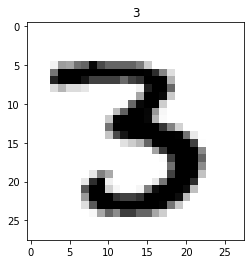

In [ ]:
index=12;
plt.title((y_train[index]))
plt.imshow(x_train[index].reshape(28,28), cmap=cm.binary)

In [ ]:
print("train data")
y_value=np.zeros((1,10))
for i in range (10):
    print("occurance of ",i,"=",np.count_nonzero(y_train==i))
    y_value[0,i]= np.count_nonzero(y_train==i)

train data
occurance of  0 = 5923
occurance of  1 = 6742
occurance of  2 = 5958
occurance of  3 = 6131
occurance of  4 = 5842
occurance of  5 = 5421
occurance of  6 = 5918
occurance of  7 = 6265
occurance of  8 = 5851
occurance of  9 = 5949


<BarContainer object of 10 artists>

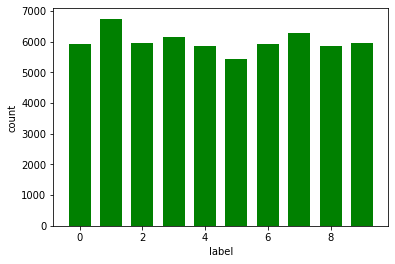

In [ ]:
y_value=y_value.ravel()
x_value=[0,1,2,3,4,5,6,7,8,9]
plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7,color='g')

#Model From Scratch

#Activation Function

In [ ]:
import numpy as np

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

def softmax(Z):
    cache = Z
    e_Z = np.exp(Z)
    s = e_Z / e_Z.sum(axis = 0)
    return s, cache

def relu_backward(dA, cache):   
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):   
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ



#Initializaion

In [ ]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
    return parameters

#Forward propagation

In [ ]:

def linear_forward(A,W,b):
    Z = np.dot(W, A) + b
    cache = (A, W , b)
    return Z ,cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'softmax')
    caches.append(cache)
    return AL, caches

#Cost Function

In [ ]:

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m) * np.sum(Y * np.log(AL))
    return cost

#Back propagation

In [ ]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    # Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    current_cache  = caches[L-1]
    linear_cache, activation_cache = current_cache
    A_prev, W, b = linear_cache
    dZL = AL - Y
    grads["dW" + str(L)] = (1/m)*np.dot(dZL, A_prev.T)
    grads["db" + str(L)] = (1/m)*np.sum(dZL, axis=1, keepdims=True)
    grads["dA" + str(L-1)] = np.dot(W.T,dZL)

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

#Update parameters

In [ ]:
def update_parameters(parameters, grads, learning_rate):  
    L = len(parameters) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters


#Train

In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1).T /255
x_test = x_test.reshape(x_test.shape[0], -1).T   /255

In [ ]:
y_train = np_utils.to_categorical(y_train)

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 1, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every iteration
        print("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
layers_dims=[784,100,10]

Cost after iteration 0: 2.302725
Cost after iteration 1: 2.294084
Cost after iteration 2: 2.281996
Cost after iteration 3: 2.260023
Cost after iteration 4: 2.218793
Cost after iteration 5: 2.142189
Cost after iteration 6: 2.008007
Cost after iteration 7: 1.800652
Cost after iteration 8: 1.543060
Cost after iteration 9: 1.298345
Cost after iteration 10: 1.108248
Cost after iteration 11: 0.995796
Cost after iteration 12: 1.391910
Cost after iteration 13: 4.526564
Cost after iteration 14: 2.190753
Cost after iteration 15: 1.834944
Cost after iteration 16: 1.640420
Cost after iteration 17: 1.347168
Cost after iteration 18: 1.229836
Cost after iteration 19: 1.215802
Cost after iteration 20: 1.609251
Cost after iteration 21: 1.633024
Cost after iteration 22: 1.479023
Cost after iteration 23: 1.287599
Cost after iteration 24: 1.025637
Cost after iteration 25: 0.884359
Cost after iteration 26: 0.859488
Cost after iteration 27: 1.106945
Cost after iteration 28: 0.979226
Cost after iteration 29:

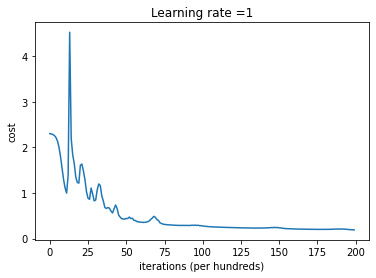

In [ ]:
parameters = L_layer_model(x_train, y_train.T, layers_dims, num_iterations = 200, print_cost = True)

#Predict and Evaluation

In [ ]:
def predict(X, y, parameters):   
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    predicted = np.argmax(probas, axis=0)

    print("Accuracy: "  + str(np.sum((predicted == y)/m)))

    return predicted, probas

In [ ]:
predicted, probas = predict(x_test, y_test, parameters)

Accuracy: 0.9468000000000003


In [ ]:
print(confusion_matrix(predicted, y_test),'\n')
print(classification_report(predicted, y_test))

[[ 965    0    8    0    1   10    7    0    6   10]
 [   0 1111    2    0    1    1    3    7    6    8]
 [   1    3  969   18    5    0    2   23    5    2]
 [   1    2    8  946    0   24    1    5   15   14]
 [   0    1    6    0  932    4    9    5    6   37]
 [   5    0    0   23    1  828    7    1    7    5]
 [   6    3   13    1   13   12  926    0   13    1]
 [   1    2   10   12    4    1    1  971    9   13]
 [   1   13   14    8    3    9    2    2  904    3]
 [   0    0    2    2   22    3    0   14    3  916]] 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1007
           1       0.98      0.98      0.98      1139
           2       0.94      0.94      0.94      1028
           3       0.94      0.93      0.93      1016
           4       0.95      0.93      0.94      1000
           5       0.93      0.94      0.94       877
           6       0.97      0.94      0.95       988
           7       0.94      0.95 